This implementation uses fully convolutional neural network for Newspaper Segmentation in JPEG domain.

* Uses Manually created dataset of newspaper including RGB image and the ground truth masked image for training and validation for classification regions of newspaper on text, picture and background areas. It contains 290 images of English newspapers. There are 4 classes: Article area, picture area, background, Heading .

* Image used in this implementaion is a DCT transformed image of the dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import glob
import numpy as np # linear algebra
import cv2
import matplotlib.pyplot as plt
from matplotlib import image
%matplotlib inline
from sklearn.model_selection import train_test_split
from google.colab import files

In [ ]:
from keras.models import Model
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from keras.models import model_from_json

In [ ]:
IMAGE_LIB = '/content/drive/MyDrive/MiniProject/DCTtransform/DCT/'
IMG_HEIGHT, IMG_WIDTH = 1024,512

In [ ]:
all_masks = [x for x in sorted(os.listdir(IMAGE_LIB)) if x[-6:-4] == '_m']
all_images = []
for i,name in enumerate(all_masks):
    for x in sorted(os.listdir(IMAGE_LIB)):
        if x.startswith(name[:-6]) and x[-6:-4] != '_m':
            all_images.append(x)
            break

In [ ]:
x_data = np.empty((len(all_images), IMG_HEIGHT, IMG_WIDTH, 3), dtype='float32')
for i, name in enumerate(all_images):
    img = cv2.imread(IMAGE_LIB + name,cv2.COLOR_BGR2RGB ).astype('float32')/255
    img = cv2.resize(img,(IMG_WIDTH, IMG_HEIGHT))
    x_data[i] = img

y_data = np.empty((len(all_masks), IMG_HEIGHT, IMG_WIDTH, 3), dtype='float32')
for i, name in enumerate(all_masks):
    img = cv2.imread(IMAGE_LIB + name,cv2.COLOR_BGR2RGB).astype('float32')/255
    img = cv2.resize(img,(IMG_WIDTH, IMG_HEIGHT))
    y_data[i] = img

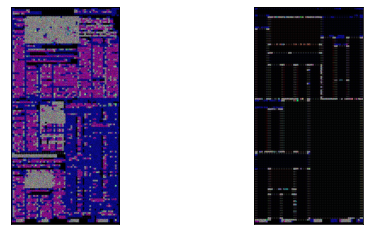

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (8,4))
ax[0].set_xticks([])
ax[1].set_xticks([])
ax[0].set_yticks([])
ax[1].set_yticks([])
ax[0].imshow(x_data[0])
ax[1].imshow(y_data[0])
plt.show()

In [ ]:
x_data.shape

(145, 1024, 512, 3)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.3)

In [ ]:
input_layer = Input(shape=x_train.shape[1:])
c1 = Conv2D(filters=8, kernel_size=(7,7), activation='relu', padding='same')(input_layer)
l = MaxPool2D(strides=(2,2))(c1)
c2 = Conv2D(filters=16, kernel_size=(5,5), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c2)
c3 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c3)
c4 = Conv2D(filters=32, kernel_size=(1,1), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(c4), c3], axis=-1)
l = Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c2], axis=-1)
l = Conv2D(filters=24, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c1], axis=-1)
l = Conv2D(filters=16, kernel_size=(2,2), activation='relu', padding='same')(l)
l = Conv2D(filters=64, kernel_size=(1,1), activation='relu')(l)
l = Dropout(0.5)(l)
output_layer = Conv2D(filters=3, kernel_size=(1,1), activation='sigmoid')(l)
                                                         
model = Model(input_layer, output_layer)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 8)  1184        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 8)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 3216        max_pooling2d[0][0]              
______________________________________________________________________________________________

In [ ]:
dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 5, 
                  width_shift_range = 0.05, 
                  height_shift_range = 0.05, 
                  shear_range = 0.025,
                  zoom_range = [0.9, 2.5],  
                  horizontal_flip = True, 
                  vertical_flip = False,
                  fill_mode = 'nearest',
                   data_format = 'channels_last')
image_gen = ImageDataGenerator()

def my_generator(x_train, y_train, batch_size):
    SEED = np.random.choice(range(9999))
    data_generator = image_gen.flow(x_train, y=None, batch_size=batch_size, seed=SEED)
    mask_generator = image_gen.flow(y_train, y=None, batch_size=batch_size, seed=SEED)
    while True:
        x_batch = data_generator.next()
        y_batch = mask_generator.next()
        yield x_batch, y_batch

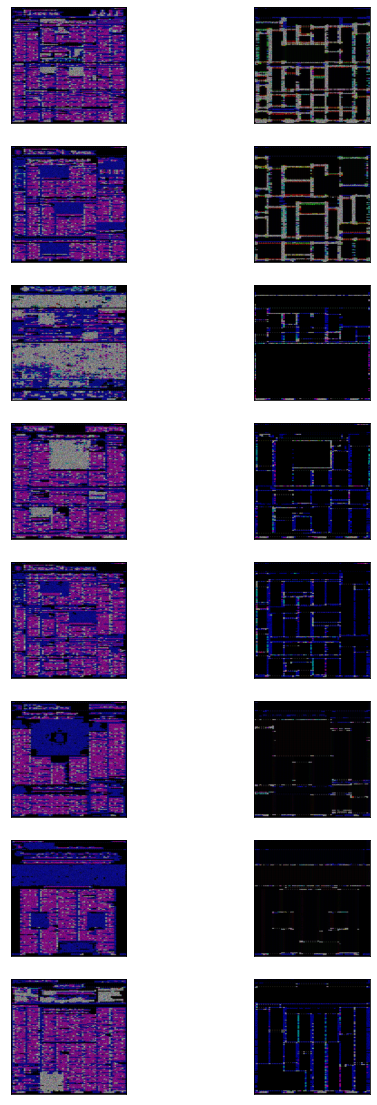

In [ ]:
image_batch, mask_batch = next(my_generator(x_train, y_train, 8 ))
fix, ax = plt.subplots(8,2, figsize=(8,20))
for i in range(8):
    ax[i,0].set_xticks([])
    ax[i,1].set_xticks([])
    ax[i,0].set_yticks([])
    ax[i,1].set_yticks([])
    ax[i,0].imshow(image_batch[i,:,:,:])
    ax[i,1].imshow(mask_batch[i,:,:,:])
plt.show()

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])

In [ ]:
weight_saver = ModelCheckpoint('Dct.h5', monitor='val_accuracy', save_best_only=True)
early = EarlyStopping(monitor='accuracy', patience=3, verbose=1, mode='min')

In [ ]:
hist = model.fit_generator(my_generator(x_train, y_train, 8),
                           steps_per_epoch = 100,
                           validation_data = (x_test, y_test),
                           epochs=20, verbose=1,
                           callbacks = [weight_saver])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
100/100 [==============================] - 14s 128ms/step - loss: 0.2120 - accuracy: 0.3205 - val_loss: 0.1885 - val_accuracy: 0.3138
Epoch 2/20
100/100 [==============================] - 12s 125ms/step - loss: 0.2031 - accuracy: 0.3279 - val_loss: 0.1845 - val_accuracy: 0.3396
Epoch 3/20
100/100 [==============================] - 12s 125ms/step - loss: 0.2020 - accuracy: 0.3299 - val_loss: 0.1839 - val_accuracy: 0.3242
Epoch 4/20
100/100 [==============================] - 13s 125ms/step - loss: 0.1997 - accuracy: 0.3260 - val_loss: 0.1821 - val_accuracy: 0.3318
Epoch 5/20
100/100 [==============================] - 12s 124ms/step - loss: 0.1970 - accuracy: 0.3271 - val_loss: 0.1824 - val_accuracy: 0.3285
Epoch 6/20
100/100 [==============================] - 12s 124ms/step - loss: 0.1978 - accuracy: 0.3290 - val_loss: 0.1822 - val_accuracy: 0.3425
Epoch 7/20
100/100 [==============================] - 12s 125ms/step - loss: 0.1924 - accuracy: 0.3259 - val_loss: 0.1819 - val_ac

In [ ]:
trainingscore = model.evaluate(x_train, y_train, batch_size=8, verbose=0)
print(trainingscore[0])
print(trainingscore[1])

testingscore = model.evaluate(x_test, y_test, batch_size=8, verbose=0)
print(testingscore[0])
print(testingscore[1])

0.16065983474254608
0.7243835926055908
0.18043656647205353
0.7337726354598999


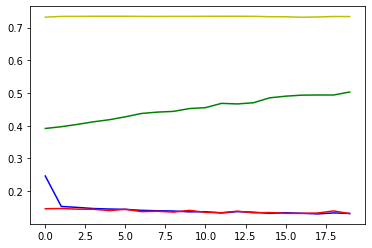

In [ ]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.plot(hist.history['accuracy'], color='g')
plt.plot(hist.history['val_accuracy'], color='y')
plt.show()

In [ ]:
y_hat = model.predict(x_test)
for i in range(0,9):
  offset = 0
  im_rows = 1
  im_cols = 3
  fig, ax = plt.subplots(offset + im_rows, im_cols, figsize=(80,80))
  ax[0].set_xticks([])
  ax[1].set_xticks([])
  ax[2].set_xticks([])
  ax[0].set_yticks([])
  ax[1].set_yticks([])
  ax[2].set_yticks([])
  ax[0].imshow(x_test[i,:,:,:])
  ax[1].imshow(y_test[i,:,:,:])
  ax[2].imshow(y_hat[i,:,:,:])

***# ------------------------------------------------------------- For Testing Purpose Only ----------------------------------------------------------------------#*** 

1. ***Save Model architecture into json file***
2. ***Save Model HDF5 weight***

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

# save to google drive
!cp model.json "/content/drive/MyDrive/MiniProject/SavedModel/Dct/"
!cp model.h5 "/content/drive/MyDrive/MiniProject/SavedModel/Dct/"


Saved model to disk


1. ***Load saved Model*** 
2. ***Load saved Weight*** 

In [ ]:
model_path ='/content/drive/MyDrive/MiniProject/SavedModel/Dct/model.json'
weight_path = '/content/drive/MyDrive/MiniProject/SavedModel/Dct/model.h5'

# load json and create model
#json_file = open('model.json', 'r')
json_file = open(model_path, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
#loaded_model.load_weights("model.h5")
loaded_model.load_weights(weight_path)
print("Loaded model from disk")


Loaded model from disk


***Evaluate the loaded model***

In [ ]:
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
Trainscore = loaded_model.evaluate(x_train, y_train, batch_size = 8, verbose=0)
Testscore = loaded_model.evaluate(x_test, y_test, batch_size = 8, verbose=0)
print("Train loss  : " + str(Trainscore[0]*100))
print("Train Accuracy  : " + str(Trainscore[1]*100))
print("Test Loss  : " + str(Testscore[0]*100))
print("Test Accuracy  : " + str(Testscore[1]*100))

Train loss  : 25.557467341423035
Train Accuracy  : 54.9343466758728
Test Loss  : 25.813284516334534
Test Accuracy  : 55.34605383872986


In [ ]:
y_hat = loaded_model.predict(x_test)
for i in range(0,9):
  offset = 0
  im_rows = 1
  im_cols = 3
  fig, ax = plt.subplots(offset + im_rows, im_cols, figsize=(80,80))
  ax[0].set_xticks([])
  ax[1].set_xticks([])
  ax[2].set_xticks([])
  ax[0].set_yticks([])
  ax[1].set_yticks([])
  ax[2].set_yticks([])
  ax[0].imshow(x_test[i,:,:,:])
  ax[1].imshow(y_test[i,:,:,:])
  ax[2].imshow(y_hat[i,:,:,:])